# 実用上のモデルチューニング
本単元でも、pytorchの様々な機能ついて紹介する。  
ここまででは扱いきれなかった、レイヤーの紹介やモデルの紹介、学習済みのモデルを利用する方法の紹介を行う。  

## この単元の目標
- 色々なレイヤーを知ろう
- 色々なモデルを知ろう

In [1]:
# 本章で使うモジュール
import torch
from torch import nn

## 1. CNNやLSTMなどのレイヤークラスによるモデルチューニング
---

ここまで簡単なMLPモデルを組み立てたが、レイヤーとしては「全結合層( nn.Linear)」の利用に限られた。  
他にも有名なレイヤーとして「ドロップアウト層」「畳み込み層」「プーリング層」「長短期記憶層」が挙げられる。

そこで、この章ではPyTorchで実装されている上記の5つの層の使い方と機能を学んでいこう。

---
**【全結合層 (nn.Linear)】**  
* 全ての入力ノードに対して全ての出力ノードへ演算（アフィン変換）を行う層で、モデルの出力層付近など、多くのケースで広く使われている。
* 重みとバイアスの2種類の学習可能なパラメータを持つ
* 活性化関数：中間層はrelu, tanh、出力層はsigmoid, softmaxなどを適用することが多い

---
**【ドロップアウト層 (nn.Dropout)】**  
* 過学習回避のために正則化を行う層で、非常に実用性が高く、ほぼ全てのモデルに対して適用することが容易
* 機能：学習時にノードのうちのいくつかをランダムに無効にすることで過学習を緩和し、精度の向上が見込める
    * いくつを無効にするかはハイパーパラメータとして定める必要がある  
* 活性化関数：適用しないことが多い

---
**【畳み込み層 (nn.Conv2d)】**  
* **カーネル**と呼ばれるフィルターを通して特徴量を抽出する層で、特に画像を扱うDL手法(CNN)でプーリング層とセットで用いられることが多い
* カーネルを学習可能なパラメータとして持つ
* 第1引数には入力のチャネル数、第2引数には出力のチャネル数、第3引数にはカーネルの一辺のサイズを指定する
* 活性化関数：プーリング層を適用することが多い

---
**【プーリング層 (nn.MaxPool2d)】**  
* 重要な特徴量のみ抽出することでデータの圧縮を行う層、畳み込み→活性化関数→プーリングの順で利用することが多い
* 過学習緩和・ロバスト性の向上・計算量削減などの効果が見込める
* 代表的な抽出方法は「最大値プーリング・平均値プーリング」の2種類
* 活性化関数：適用しない（プーリング層は活性化関数の作用をする）  

---
**【長短期記憶層 (nn.LSTM)】**  
* 自己ループを持つことで内部の状態を持続させることができる層、特に言語を扱うDL手法(RNN)で利用されている
* **ゲート**と呼ばれる構造により情報の流れを制御し、勾配消失問題を解消することができる
* 活性化関数：sigmoid, tanhなど適用することが多い

---

【例題】 以下のコードを実行して、それぞれのレイヤー(畳み込み層)の挙動を確認する。  
畳み込み層は、入力チャネル数=3, 出力チャネル数=5, カーネルのサイズ=3\*3とする。  
畳み込むデータ(Tensor)は1枚の画像データで28*28のサイズでRGBの3色(次元)で表現されたものとする。(要素内はランダムとする)

In [2]:
conv = nn.Conv2d(3,5,3)  # 入力チャネル数=3, 出力チャネル数=5, カーネルのサイズ=3*3でクラスを宣言

x = torch.Tensor(torch.rand(1,3,28,28))  # 1枚の画像が3次元(=入力チャネル)で28*28のサイズ
x = conv(x)  # 畳み込みの実行

print(x.shape)

torch.Size([1, 5, 26, 26])


- ```
torch.Size([1, 5, 26, 26])
```
と表示されていれば成功だ。

１枚の画像データが畳み込み処理を終えて、チャネルが5, サイズが26\*26へ変化した事がわかる。




【問題】 【例題】に従って畳み込み層を利用して、処理後のデータの形を出力しよう。  
畳み込み層は、入力チャネル数=1, 出力チャネル数=2, カーネルのサイズ=3\*3とする。  
畳み込むデータ(Tensor)は100枚の画像データで64*64のサイズでRGBの1色(次元)で表現されたものとする。(要素内はランダムとする)

In [3]:
conv = nn.Conv2d(1,2,3)
x = torch.Tensor(torch.rand(100,1,64,64))
x = conv(x)
print(x.shape)

torch.Size([100, 2, 62, 62])


- ```
torch.Size([100, 2, 62, 62])
```
と表示されていれば成功だ。

## 2. 構築済みモデルと学習済みモデルの使い方
最後に扱うのは、構築済みの**モデル**と学習済みの**モデル**だ。  
構築済みのモデルというのは、自身でレイヤーや関数を用意し組み立てるのではなく、既に他者がある目的のため組み上げたモデルのことを指す。  
ここでは、ILSVRCという画像認識のDLコンテストで有名になった2つのCNNモデルを紹介するぞ！
学習済みのモデルと言うのは、構築済みのモデルにおいて、パラメータの学習まで完了しているもののことを指す。
「手元にあるデータをディープラーニングで扱えるのか、取り敢えず簡単に試してみる」時に有用だぞ！

**【VGG】**  2014年準優勝モデル

特徴：**シンプル**かつパワフルな構造(21層)

||今までのモデル|VGG|
|:-:|:-:|:-:|
|畳み込み層のフィルタ数|バラバラ|3*3で統一|
|プーリング層のフィルタ数|バラバラ|2*2で統一|
|学習パラメータ数|多い|少ない|
|計算量|多い|少ない|
|過学習|しやすい|しにくい|

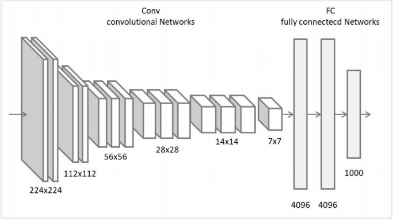

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|畳<br>み<br>込<br>み<br>層|畳<br>み<br>込<br>み<br>層|プ<br>｜<br>リ<br>ン<br>グ<br>層|畳<br>み<br>込<br>み<br>層|畳<br>み<br>込<br>み<br>層|プ<br>｜<br>リ<br>ン<br>グ<br>層|畳<br>み<br>込<br>み<br>層|畳<br>み<br>込<br>み<br>層|畳<br>み<br>込<br>み<br>層|プ<br>｜<br>リ<br>ン<br>グ<br>層|畳<br>み<br>込<br>み<br>層|畳<br>み<br>込<br>み<br>層|畳<br>み<br>込<br>み<br>層|プ<br>｜<br>リ<br>ン<br>グ<br>層|畳<br>み<br>込<br>み<br>層|畳<br>み<br>込<br>み<br>層|畳<br>み<br>込<br>み<br>層|プ<br>｜<br>リ<br>ン<br>グ<br>層|全<br>結<br>合<br>層|全<br>結<br>合<br>層|全<br>結<br>合<br>層|

上記の図と表のような構成で作られている。

* 使い方：pytorchでは、vggモデルを`torchvision.models.vgg11()`クラスでインスタンスとして宣言できる。 

【vggのコード例】

In [4]:
from torchvision import models

class vgg(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg11()
        self.fc = nn.Linear(1000, 10)  # 出力ラベル数を10と想定

    def forward(self, x):
        x = self.vgg(x)
        x = self.fc(x)
        return x
    
model1 = vgg()
print(model1)

vgg(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_size=2, str

出力にはVGGを構成する層と活性化関数の内容が表示される。  
モデルを呼び出すことで、モデルの組み立てをほぼしなくて済むので非常に便利だ！

**【ResNet】**  2015年優勝モデル

特徴：**勾配消失**を解消する構造を作り、今までのモデルと比較して層を一段と深くできるようにした（152層：内21層はVGG）
* 勾配を伝搬するショートカット構造(Residual Block)

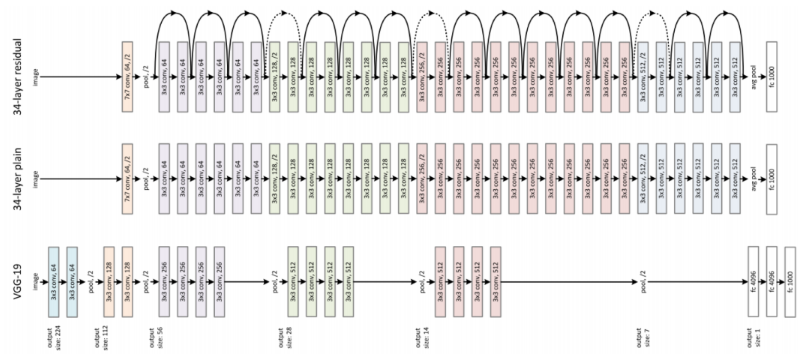

* 使い方：pytorchでは、ResNetモデルを`torchvision.models.resnet18()`クラスでインスタンスとして宣言できる。

【resnetのコード例】

In [5]:
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18()
        self.fc = nn.Linear(1000, 10)  # 出力ラベル数を10と想定

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x
    
model1 = resnet()
print(model1)

resnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

出力にはResNetを構成する層と活性化関数の内容が表示される。  

最新のILSVRCではどのようなモデルが優勝したのか余裕があれば調べてみよう！


学習済みのモデルを使う際には、構築済みモデルを使用するときの`torchvision.models.vgg11()`や`torchvision.models.resnet18()`の引数に`pretrained=True`を指定することで使うことができるぞ！

【resnetでの使用例】

In [6]:
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.fc = nn.Linear(1000, 10)  # 出力ラベル数を10と想定

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x
    
model1 = resnet()
print(model1)


resnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni